In [104]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

### Get R,G,B,W patchs information

Text(0.5, 0, 'wavelength [nm]')

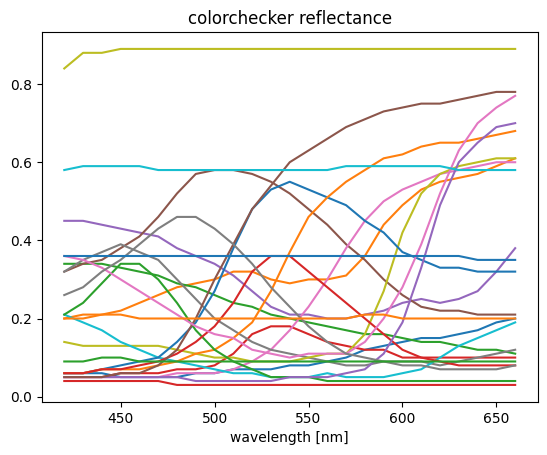

In [105]:
# Replace 'file.csv' with the path to your CSV file
file_path = '../../dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61
wvls_CC = wvls_CC[ind_min:ind_max:2] 
ref_CC = ref_CC[ind_min:ind_max:2,:]

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC[1:-2], ref_CC[1:-2])
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [106]:
blue = ref_CC[1:-2,12] # 87, 370
green = ref_CC[1:-2,13] # 218, 370
red = ref_CC[1:-2,14] # 349, 376
white = ref_CC[1:-2,18] # 74, 500

blue = torch.tensor(blue.astype(np.float32))
green = torch.tensor(green.astype(np.float32))
red = torch.tensor(red.astype(np.float32))
white = torch.tensor(white.astype(np.float32))

In [107]:
center_pts = np.array([[349, 376],[218, 370], [87, 370],[74, 500]]) # R, G, B, W

### Projector & Camera response function / Initial values

In [108]:
# bring initial value of PEF and CRF
PEF = torch.tensor(np.load('../../dataset/image_formation/CRF_proj.npy')[2:27])
CRF = torch.tensor(np.load('./CRF.npy').T)

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x2c89e3b35c8>])

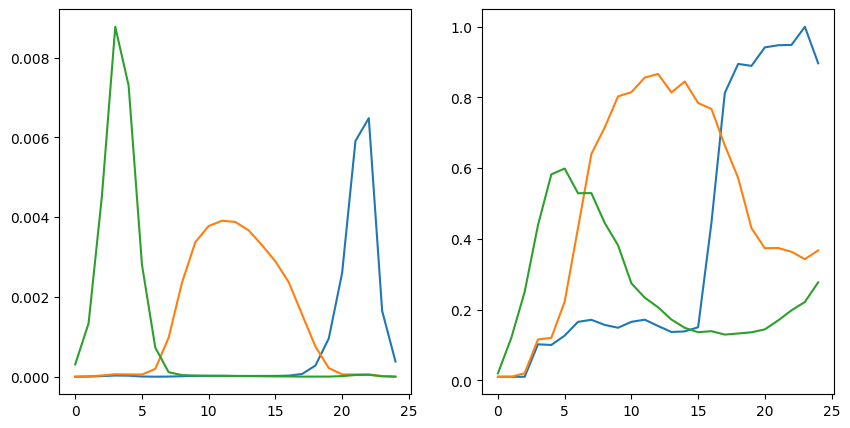

In [109]:
# Plot PEF and CRF
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.plot(PEF)
plt.subplot(122), plt.plot(CRF)

### GT Image

In [110]:
# Bring white pattern illuminated colorchecker and black pattern illuminated pattern
white_color_checker = cv2.imread('./crf_datas/white_color_checker.png', -1)[:,:,::-1] / 65535.
black_color_checker = cv2.imread('./crf_datas/black_color_checker.png', -1)[:,:,::-1] / 65535.

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x2c89e41e248>)

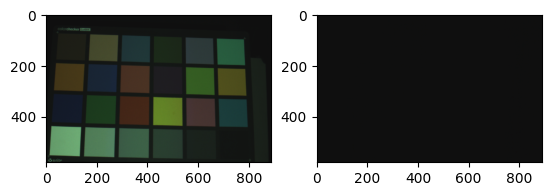

In [111]:
# image plotting
plt.subplot(121), plt.imshow(white_color_checker)
plt.subplot(122), plt.imshow(black_color_checker)

In [112]:
# Ground truth image (subtracted black image)
GT_image = white_color_checker - black_color_checker

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.6337987335011825 -0.004882887006942858


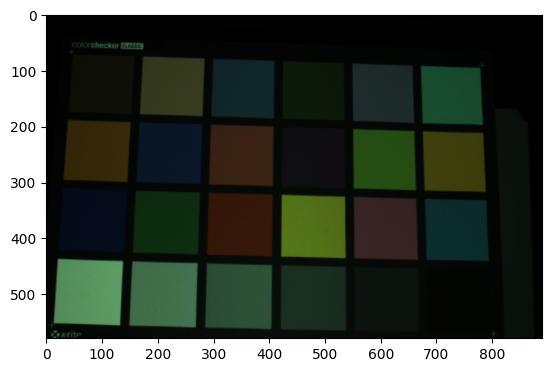

In [94]:
plt.imshow(GT_image)
print(GT_image.max(), GT_image.min())

### Optimization

In [121]:
# # arguments
# device = 'cuda:0'
# epoch = 5000
# loss_f = torch.nn.L1Loss()
# losses = [] 
# # Height, width of image
# H, W = 1, 1
# # white pattern illuminated
# white_pattern = torch.ones(size = (H, W, 3), device = device)
    
# # learning rate & decay step
# lr = 0.5
# decay_step = 800
# gamma = 0.8

# # optimized paramter (CRF & PEF)
# # initial_value = torch.hstack((PEF, CRF))
# PEF, CRF = torch.tensor(PEF, dtype = torch.float, device = device), torch.tensor(CRF, dtype = torch.float, device = device)
# initial_value = torch.tensor([0.5, 0.5])
# opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# # to device
# red, green, blue, white = red.to(device), green.to(device), blue.to(device), white.to(device)
# GT_image = torch.tensor(GT_image, device = device)

# optimizer = torch.optim.Adam([opt_param], lr = lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# for i in range(epoch):
    
#     white_pattern_hyp = white_pattern @ (opt_param[0]*PEF.T) # opt_param[:,:3] = PEF

#     # rgb intensity of each patch
#     red_patch = (white_pattern_hyp * red) @ (opt_param[1] * CRF) # opt_param[:,3:] = CRF
#     green_patch = (white_pattern_hyp * green) @ (opt_param[1] * CRF)
#     blue_patch = (white_pattern_hyp * blue) @ (opt_param[1] * CRF)
#     white_patch = (white_pattern_hyp * white) @ (opt_param[1] * CRF)

#     # GT image for each patch
#     gt_red_patch = GT_image[center_pts[0,1], center_pts[0,0]] # 0
#     gt_green_patch = GT_image[center_pts[1,1], center_pts[1,0]] # 1
#     gt_blue_patch = GT_image[center_pts[2,1], center_pts[2,0]] # 2
#     gt_white_patch = GT_image[center_pts[3,1], center_pts[3,0]] # 3
        
#     loss_red = loss_f(red_patch, gt_red_patch)
#     loss_green = loss_f(green_patch, gt_green_patch)
#     loss_blue = loss_f(blue_patch, gt_blue_patch)
#     loss_white = loss_f(white_patch, gt_white_patch)
    
#     loss = loss_red + loss_green + loss_blue + loss_white
    
#     optimizer.zero_grad()
#     loss.backward()
#     losses.append(loss.item() / 4)
#     optimizer.step()
#     scheduler.step()

    
#     if i % 500 == 0:
#         print(f" Opt param value : {opt_param}, Epoch : {i}/{epoch}, Loss: {loss.item() / 4}, LR: {optimizer.param_groups[0]['lr']}")
        
#         # plt.figure()
#         # plt.xlabel('epoch')
#         # plt.ylabel('loss')
#         # plt.plot(losses)

In [119]:
# arguments
device = 'cuda:0'
epoch = 5000
loss_f = torch.nn.L1Loss()
losses = [] 
# Height, width of image
H, W = 1, 1
# white pattern illuminated
white_pattern = torch.ones(size = (H, W, 3), device = device)
    
# learning rate & decay step
lr = 0.5
decay_step = 800
gamma = 0.8

# optimized paramter (CRF & PEF)
initial_value = torch.hstack((PEF, CRF))
opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# to device
red, green, blue, white = red.to(device), green.to(device), blue.to(device), white.to(device)
GT_image = torch.tensor(GT_image, device = device)

optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

for i in range(epoch):
    
    white_pattern_hyp = white_pattern @ opt_param[:,:3].T # opt_param[:,:3] = PEF

    # rgb intensity of each patch
    red_patch = (white_pattern_hyp * red) @ opt_param[:,3:] # opt_param[:,3:] = CRF
    green_patch = (white_pattern_hyp * green) @ opt_param[:,3:]
    blue_patch = (white_pattern_hyp * blue) @ opt_param[:,3:]
    white_patch = (white_pattern_hyp * white) @ opt_param[:,3:]

    # GT image for each patch
    gt_red_patch = GT_image[center_pts[0,1], center_pts[0,0]] # 0
    gt_green_patch = GT_image[center_pts[1,1], center_pts[1,0]] # 1
    gt_blue_patch = GT_image[center_pts[2,1], center_pts[2,0]] # 2
    gt_white_patch = GT_image[center_pts[3,1], center_pts[3,0]] # 3
        
    loss_red = loss_f(red_patch, gt_red_patch)
    loss_green = loss_f(green_patch, gt_green_patch)
    loss_blue = loss_f(blue_patch, gt_blue_patch)
    loss_white = loss_f(white_patch, gt_white_patch)
    
    loss = loss_red + loss_green + loss_blue + loss_white
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / 4)
    optimizer.step()
    scheduler.step()

    
    if i % 500 == 0:
        print(f" Opt param value : {opt_param}, Epoch : {i}/{epoch}, Loss: {loss.item() / 4}, LR: {optimizer.param_groups[0]['lr']}")
        
        # plt.figure()
        # plt.xlabel('epoch')
        # plt.ylabel('loss')
        # plt.plot(losses)


c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\torch\nn\modules\loss.py:101: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([1, 1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


 Opt param value : tensor([[0.5000, 0.5000, 0.5003, 0.5100, 0.5100, 0.5200],
        [0.5000, 0.5000, 0.5013, 0.5100, 0.5100, 0.6200],
        [0.5000, 0.5000, 0.5045, 0.5100, 0.5200, 0.7500],
        [0.5000, 0.5001, 0.5088, 0.6019, 0.6157, 0.9389],
        [0.5000, 0.5001, 0.5073, 0.6000, 0.6200, 1.0826],
        [0.5000, 0.5001, 0.5028, 0.6264, 0.7223, 1.0990],
        [0.5000, 0.5002, 0.5007, 0.6654, 0.9312, 1.0291],
        [0.5000, 0.5010, 0.5001, 0.6712, 1.1402, 1.0295],
        [0.5000, 0.5024, 0.5000, 0.6567, 1.2151, 0.9451],
        [0.5000, 0.5034, 0.5000, 0.6487, 1.3032, 0.8819],
        [0.5000, 0.5038, 0.5000, 0.6654, 1.3150, 0.7743],
        [0.5000, 0.5039, 0.5000, 0.6715, 1.3562, 0.7337],
        [0.5000, 0.5039, 0.5000, 0.6536, 1.3666, 0.7065],
        [0.5000, 0.5037, 0.5000, 0.6367, 1.3142, 0.6719],
        [0.5000, 0.5033, 0.5000, 0.6384, 1.3452, 0.6484],
        [0.5000, 0.5029, 0.5000, 0.6501, 1.2844, 0.6361],
        [0.5000, 0.5024, 0.5000, 0.9462, 1.2675, 0.63

(<AxesSubplot:>,
  <matplotlib.lines.Line2D at 0x2c8a605f148>])

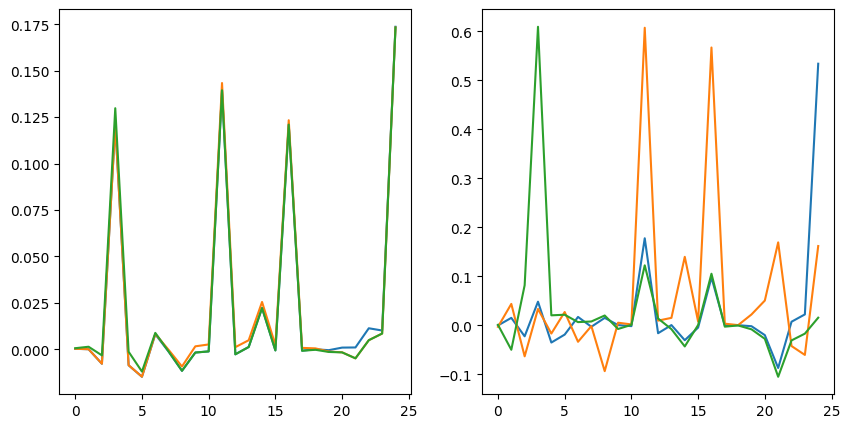

In [120]:
# Plot PEF and CRF
plt.figure(figsize=(10, 5))
plt.subplot(121), plt.plot(opt_param.detach().cpu().numpy()[:,:3])
plt.subplot(122), plt.plot(opt_param.detach().cpu().numpy()[:,3:])

In [102]:
red_patch = (white_pattern_hyp * red) @ opt_param[:,3:]
gt_red_patch = GT_image[center_pts[0,1], center_pts[0,0]]

In [103]:
print(red_patch, gt_red_patch)

tensor([[[0.2139, 0.0777, 0.0252]]], device='cuda:0',
       grad_fn=<UnsafeViewBackward0>) tensor([0.2129, 0.0928, 0.0352], device='cuda:0', dtype=torch.float64)
